<a href="https://colab.research.google.com/github/KarolineCostadaSilva/EDA-sales-stores/blob/main/Sales_Stores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Importação das bibliotecas

In [9]:
!pip install plotly

In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


import calendar

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected = True)

# Sobre o dataset

O dataset Store Sales está disponível no Kaggle, no qual está disponível para prever as vendas das milhares de famílias de produtos vendidos nas lojas Favorita localizadas no Equador. Os dados de treinamento incluem datas, informações da loja e do produto, se aquele item estava sendo promovido, bem como os números de vendas. Arquivos adicionais incluem informações complementares que podem ser úteis na construção de modelos.

Esse notebook corresponde uma Análise Exploratória de Dados sobre os datasets.

# Importando os datasets

In [2]:
df_holi = pd.read_csv('/content/holidays_events.csv')
df_oil = pd.read_csv('/content/oil.csv')
df_stores = pd.read_csv('/content/stores.csv')
df_trans = pd.read_csv('/content/transactions.csv')
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


<ipython-input-31-1c4e5bfa3453>:42: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



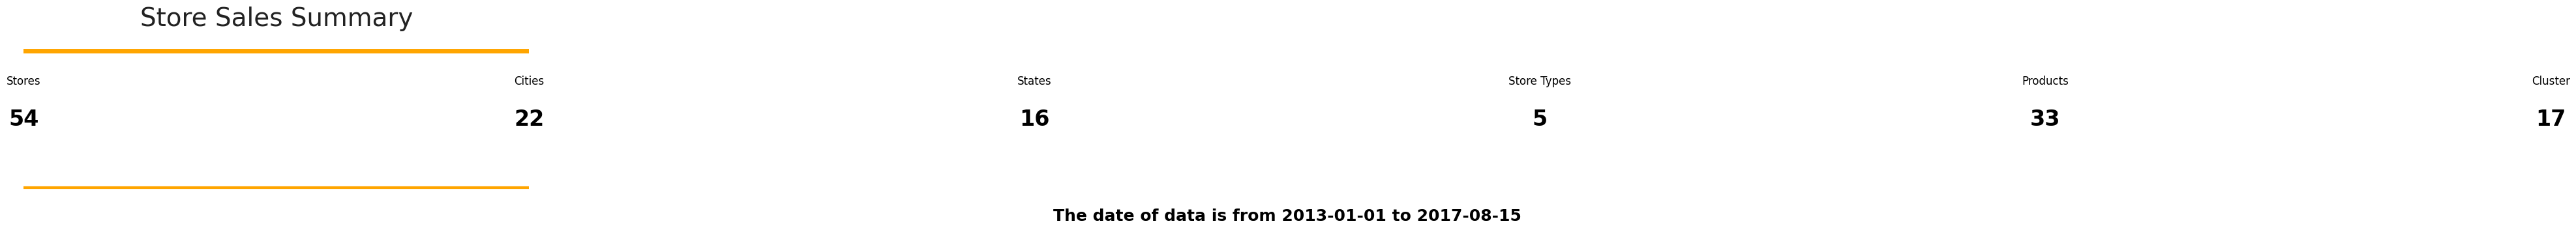

In [31]:
import matplotlib.pyplot as plt
stores_num = df_stores.shape[0]
type_store_num = len(df_stores.groupby('type').size())
product_num = len(df_train.groupby('family').size())
cities_num = len(df_stores.groupby('city').size())
state_num = len(df_stores.groupby('state').size())

#df_train['date'] = pd.to_datetime(df_train['date'])
df_train.sort_values(by=['date'], inplace=True, ascending = True)
first_date=(df_train["date"].iloc[0])#.strftime("%Y-%m-%d")
last_date=(df_train["date"].iloc[-1])#.strftime("%Y-%m-%d")

# Valores para o gráfico
categories = ['Stores', 'Cities', 'States', 'Store Types', 'Products', 'Cluster']
counts = [stores_num, cities_num, state_num, type_store_num, product_num, 17]
dates_text = f'The date of data is from {first_date} to {last_date}'

fig, ax = plt.subplots(figsize=(10, 3))

# Adiciona o texto das categorias
for i, category in enumerate(categories):
    ax.text(i, 1.7, category, ha='center', va='bottom', fontsize=12)

# Adiciona o texto dos valores
for i, count in enumerate(counts):
    ax.text(i, 1.1, f'{count}', ha='center', va='bottom', fontsize=24, fontweight='bold')

# Linhas horizontais
ax.axhline(y=2.2, color='orange', linewidth=5)
ax.axhline(y=0.3, color='orange', linewidth=3)

# Texto das datas
ax.text(2.5, -0.2, dates_text, ha='center', va='bottom', fontsize=18, fontweight='bold')

# Esconde os eixos
ax.axis('off')

# Título
plt.title('Store Sales Summary', fontsize=28, color='#222', pad=20)

# Mostra o gráfico
plt.tight_layout()
plt.show()


# Concatenando os datasets

In [5]:
# copying of train data and merging other data
df_train1 = df_train.merge(df_holi, on = 'date', how='left')
df_train1 = df_train1.merge(df_oil, on = 'date', how='left')
df_train1 = df_train1.merge(df_stores, on = 'store_nbr', how='left')
df_train1 = df_train1.merge(df_trans, on = ['date', 'store_nbr'], how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

df_train1['date'] = pd.to_datetime(df_train1['date'])
df_train1['year'] = df_train1['date'].dt.year
df_train1['month'] = df_train1['date'].dt.month
df_train1['week'] = df_train1['date'].dt.isocalendar().week
df_train1['quarter'] = df_train1['date'].dt.quarter
df_train1['day_of_week'] = df_train1['date'].dt.day_name()
df_train1.sample(n=4)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week
1133065,1116402,2014-09-20,33,GROCERY I,3233.000,10,NaN,NaN,NaN,NaN,...,Quevedo,Los Rios,C,3,1169.0,2014,9,38,3,Saturday
2543219,2501066,2016-11-07,34,PREPARED FOODS,44.000,0,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,...,Guayaquil,Guayas,B,6,2182.0,2016,11,45,4,Monday
852250,844519,2014-04-20,54,HOME AND KITCHEN II,0.000,0,NaN,NaN,NaN,NaN,...,El Carmen,Manabi,C,3,1033.0,2014,4,16,2,Sunday
374465,368040,2013-07-26,35,MEATS,96.947,0,NaN,NaN,NaN,NaN,...,Playas,Guayas,C,3,452.0,2013,7,30,3,Friday


In [18]:
import numpy as np
import matplotlib as mpl

colors = {}

def colorFader(c1,c2,mix=0):  # função para misturar cores
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='#FAA831'  # Cor de início
c2='#9A4800'  # Cor de fim
n=9

colors = {}  # Dicionário de cores
for x in range(n+1):
    colors['level'+ str(n-x+1)] = colorFader(c1,c2,x/n)
colors['background'] = '#232425'
colors['text'] = '#fff'

# Exibe o dicionário de cores
colors

{'level10': '#faa831',
 'level9': '#ef9d2c',
 'level8': '#e59326',
 'level7': '#da8821',
 'level6': '#cf7d1b',
 'level5': '#c57316',
 'level4': '#ba6810',
 'level3': '#af5d0b',
 'level2': '#a55305',
 'level1': '#9a4800',
 'background': '#232425',
 'text': '#fff'}

# Análise média de vendas

10 produtos mais vendidos

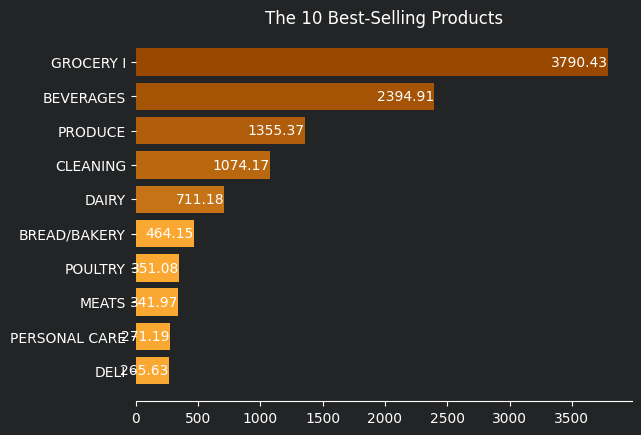

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calcula a média de vendas por família e ordena, pegando os top 10
df_fa_sa = df_train1.groupby('family').agg({"sales": "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]

# Prepara uma lista de cores para cada um dos top 10, personalizada conforme o rank
color_map = [colors['level1'], colors['level2'], colors['level3'], colors['level4'], colors['level5']] + [colors['level10']] * (len(df_fa_sa) - 5)

# Cria a figura e o eixo para o plot
fig, ax = plt.subplots()

# Plota as barras horizontais com as cores mapeadas
ax.barh(df_fa_sa['family'], df_fa_sa['sales'], color=color_map)

# Adiciona os valores de vendas como texto dentro das barras
for i, (value, name) in enumerate(zip(df_fa_sa['sales'], df_fa_sa['family'])):
    ax.text(value, i, f'{value:.2f}', va='center', ha='right', color='white')

# Define o título e personaliza o gráfico
ax.set_title('The 10 Best-Selling Products', color=colors['text'])
fig.patch.set_facecolor(colors['background'])
ax.set_facecolor(colors['background'])
ax.xaxis.label.set_color(colors['text'])
ax.yaxis.label.set_color(colors['text'])
ax.tick_params(axis='x', colors=colors['text'])
ax.tick_params(axis='y', colors=colors['text'])

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(colors['text'])

# Inverte a ordem das categorias no eixo y
ax.invert_yaxis()

plt.show()


Media de vendas por tipo de loja

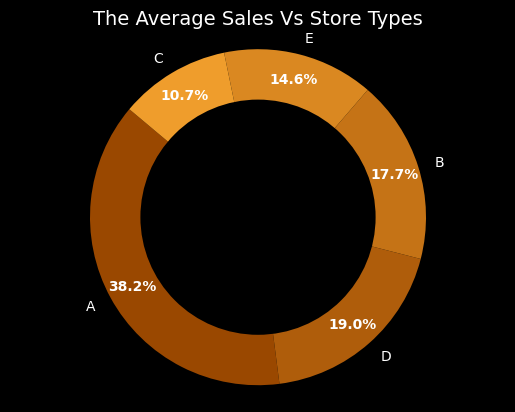

In [20]:
df_st_sa = df_train1.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
# Define as cores para o gráfico de pizza com base no dicionário 'colors'
pie_colors = [colors['level1'], colors['level3'], colors['level5'], colors['level7'], colors['level9']]

# Cria a figura e o eixo para o plot
fig, ax = plt.subplots()
# Plota o gráfico de pizza
wedges, texts, autotexts = ax.pie(df_st_sa['sales'], labels=df_st_sa['store_type'], colors=pie_colors, autopct='%1.1f%%', startangle=140, textprops=dict(color="w"), pctdistance=0.85)

# Adiciona um círculo no meio para criar o efeito de donut
centre_circle = plt.Circle((0,0),0.70,fc='black')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Iguala a razão de aspecto para que o pie seja desenhado como um círculo
ax.axis('equal')

# Personaliza o título e o fundo
plt.title('The Average Sales Vs Store Types', color='white', fontsize=14)
fig.patch.set_facecolor('#000000')
ax.set_facecolor('#1f2c56')
plt.setp(texts, color='white')

# Atualiza as configurações de fonte para os autotexts (percentuais)
plt.setp(autotexts, size=10, weight="bold")

plt.show()

Clusters por venda

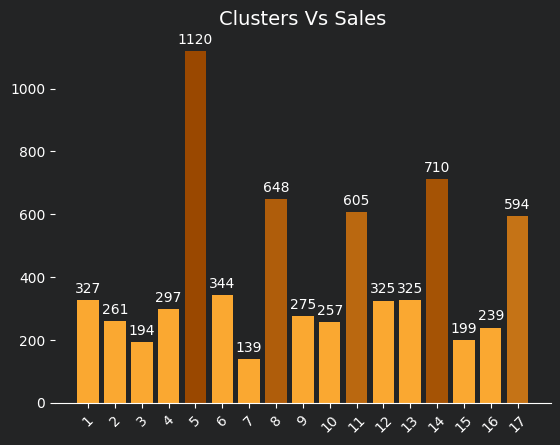

In [21]:
df_cl_sa = df_train1.groupby('cluster').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)

# Preparando as cores para cada barra baseado nos primeiros 5 clusters e o restante
color_map = [colors['level1'], colors['level2'], colors['level3'], colors['level4'], colors['level5']] + [colors['level10']] * (len(df_cl_sa) - 5)

# Cria a figura e os eixos para o plot
fig, ax = plt.subplots()

# Plota as barras verticais
bars = ax.bar(df_cl_sa['cluster'], df_cl_sa['sales'], color=color_map)

# Adiciona os valores de vendas como texto acima de cada barra
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 pontos verticais de offset
                textcoords="offset points",
                ha='center', va='bottom', color='white')

# Define o título e personaliza o gráfico
ax.set_title('Clusters Vs Sales', color='white', fontsize=14)
fig.patch.set_facecolor(colors['background'])
ax.set_facecolor(colors['background'])
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('white')

# Remove o grid do eixo y
ax.yaxis.grid(False)

# Ajusta os ticks do eixo x para mostrar todos os clusters
ax.set_xticks(df_cl_sa['cluster'])
ax.set_xticklabels(df_cl_sa['cluster'], rotation=45)

plt.show()


Média de venda por cidade

<ipython-input-22-167b2c5122be>:37: UserWarning:

FixedFormatter should only be used together with FixedLocator



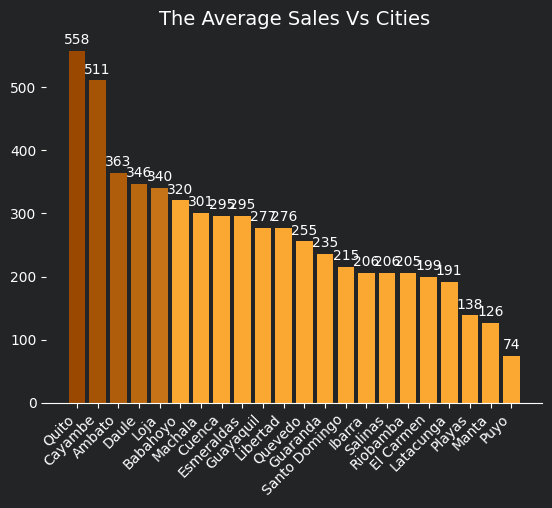

In [22]:
df_city_sa = df_train1.groupby('city').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)

# Preparando as cores para cada barra baseado nos primeiros 5 valores e o restante
color_map = [colors['level1'], colors['level2'], colors['level3'], colors['level4'], colors['level5']] + [colors['level10']] * (len(df_city_sa) - 5)

# Cria a figura e os eixos para o plot
fig, ax = plt.subplots()

# Plota as barras verticais
bars = ax.bar(df_city_sa['city'], df_city_sa['sales'], color=color_map)

# Adiciona os valores de vendas como texto acima de cada barra
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 pontos verticais de offset
                textcoords="offset points",
                ha='center', va='bottom', color='white')

# Define o título e personaliza o gráfico
ax.set_title('The Average Sales Vs Cities', color='white', fontsize=14)
fig.patch.set_facecolor(colors['background'])
ax.set_facecolor(colors['background'])
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('white')

# Ajusta os ticks do eixo x para mostrar todos os nomes das cidades, possivelmente rotacionando-os para melhor leitura
ax.set_xticklabels(df_city_sa['city'], rotation=45, ha="right")

# Remove o grid do eixo y para um visual mais limpo
ax.yaxis.grid(False)

plt.show()


Média de venda por Estado

<ipython-input-23-8adedaff74ae>:37: UserWarning:

FixedFormatter should only be used together with FixedLocator



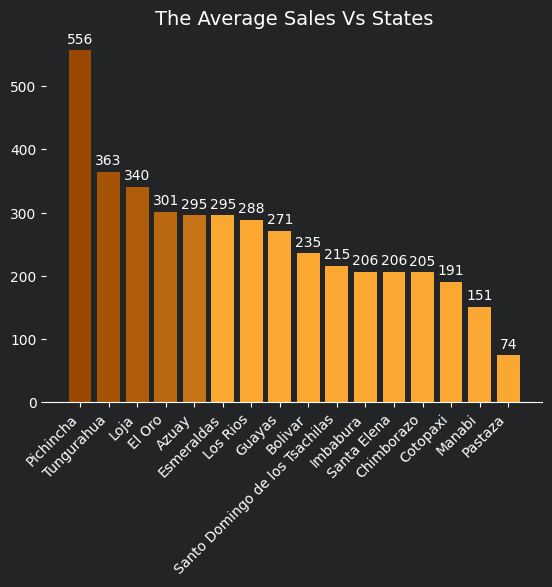

In [23]:
df_state_sa = df_train1.groupby('state').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)

# Preparando as cores para cada barra baseado nos primeiros 5 estados e o restante
color_map = [colors['level1'], colors['level2'], colors['level3'], colors['level4'], colors['level5']] + [colors['level10']] * (len(df_state_sa) - 5)

# Cria a figura e os eixos para o plot
fig, ax = plt.subplots()

# Plota as barras verticais
bars = ax.bar(df_state_sa['state'], df_state_sa['sales'], color=color_map)

# Adiciona os valores de vendas como texto acima de cada barra
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 pontos verticais de offset
                textcoords="offset points",
                ha='center', va='bottom', color='white')

# Define o título e personaliza o gráfico
ax.set_title('The Average Sales Vs States', color='white', fontsize=14)
fig.patch.set_facecolor(colors['background'])
ax.set_facecolor(colors['background'])
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('white')

# Ajusta os ticks do eixo x para mostrar todos os nomes dos estados, possivelmente rotacionando-os para melhor leitura
ax.set_xticklabels(df_state_sa['state'], rotation=45, ha="right")

# Remove o grid do eixo y para um visual mais limpo
ax.yaxis.grid(False)

plt.show()


Média de venda diária

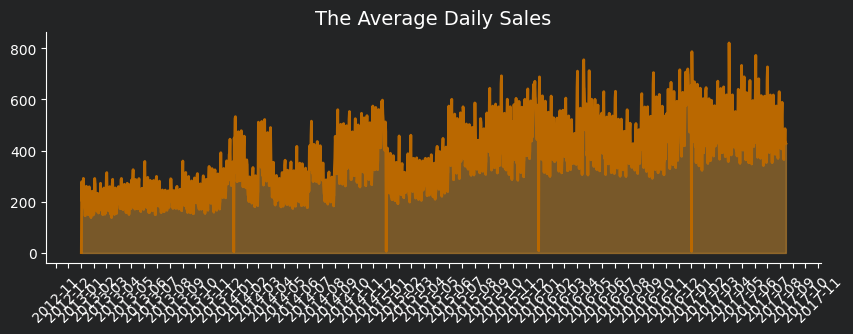

In [25]:
import matplotlib.dates as mdates

df_day_sa = df_train1.groupby('date').agg({"sales" : "mean"}).reset_index()
# Cria a figura e os eixos para o plot
fig, ax = plt.subplots(figsize=(10, 3))  # Ajuste o tamanho conforme necessário

# Plota o gráfico de linhas com preenchimento
ax.fill_between(df_day_sa['date'], df_day_sa['sales'], color='#FAA831', step="pre", alpha=0.4)
ax.plot(df_day_sa['date'], df_day_sa['sales'], color='#BA6800', linewidth=2)

# Formatação do eixo x para datas
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotação dos labels do eixo x para melhor leitura
plt.xticks(rotation=45)

# Define o título e personaliza o gráfico
ax.set_title('The Average Daily Sales', color='white', fontsize=14)
fig.patch.set_facecolor('#232425')
ax.set_facecolor('#232425')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Desabilita a grade do gráfico para os eixos x e y
ax.grid(False)

plt.show()


Média de venda semanal

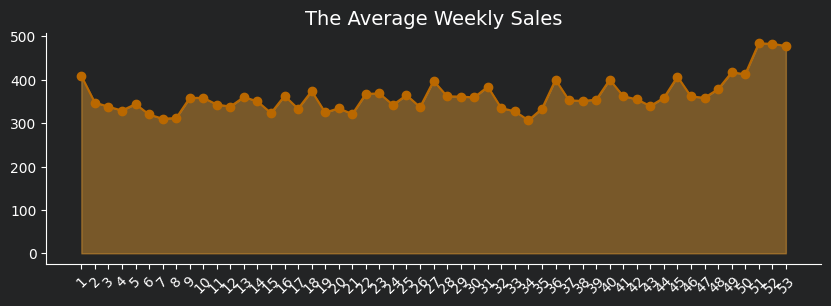

In [29]:
# Agrupa os dados por semana e calcula a média de vendas
df_w_sa = df_train1.groupby('week').agg({"sales": "mean"}).reset_index()

# Converte 'week' e 'sales' para numérico, tratando erros com 'coerce' para converter falhas em NaN
df_w_sa['week'] = pd.to_numeric(df_w_sa['week'], errors='coerce')
df_w_sa['sales'] = pd.to_numeric(df_w_sa['sales'], errors='coerce')

# Remove possíveis valores NaN que podem ter sido introduzidos pela conversão
df_w_sa.dropna(inplace=True)

# Converte 'week' para int para assegurar que é um tipo de dado numérico adequado
df_w_sa['week'] = df_w_sa['week'].astype(int)

# Remove qualquer valor infinito ou NaN que possa ter sido introduzido
df_w_sa = df_w_sa.replace([np.inf, -np.inf], np.nan).dropna(subset=['week', 'sales'])

# Cria a figura e os eixos para o plot
fig, ax = plt.subplots(figsize=(10, 3))  # Ajuste o tamanho conforme necessário

# Plota o gráfico de linhas com marcadores e preenchimento
ax.plot(df_w_sa['week'], df_w_sa['sales'], marker='o', linestyle='-', color='#BA6800', label='Average Weekly Sales')
ax.fill_between(df_w_sa['week'], 0, df_w_sa['sales'], color='#FAA831', alpha=0.4)

# Personaliza os ticks do eixo x para mostrar todas as semanas
ax.set_xticks(df_w_sa['week'])  # Garante que todos os ticks das semanas sejam mostrados
ax.set_xticklabels(df_w_sa['week'].astype(str), rotation=45)  # Rótulos personalizados das semanas

# Define o título e personaliza o gráfico
ax.set_title('The Average Weekly Sales', color='white', fontsize=14)
fig.patch.set_facecolor('#232425')
ax.set_facecolor('#232425')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Desabilita a grade do gráfico para os eixos x e y
ax.grid(False)

plt.show()


Média de venda mensal

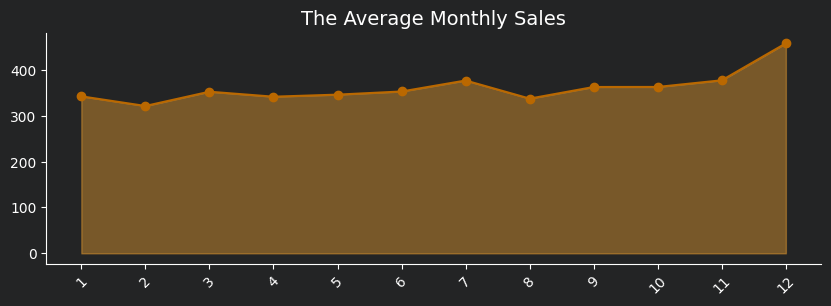

In [30]:
df_mon_sa = df_train1.groupby('month').agg({"sales" : "mean"}).reset_index()
# Cria a figura e os eixos para o plot
fig, ax = plt.subplots(figsize=(10, 3))  # Ajuste o tamanho conforme necessário

# Plota o gráfico de linhas com marcadores e preenchimento
ax.plot(df_mon_sa['month'], df_mon_sa['sales'], marker='o', linestyle='-', color='#BA6800', label='Average Monthly Sales')
ax.fill_between(df_mon_sa['month'], 0, df_mon_sa['sales'], color='#FAA831', alpha=0.4)

# Personaliza os ticks do eixo x
# Certifique-se de que 'month' esteja em um formato que possa ser usado como ticks diretamente
# Se os meses estiverem em formato numérico ou abreviado, você pode precisar ajustar os labels para uma leitura mais clara
ax.set_xticks(df_mon_sa['month'])
ax.set_xticklabels(df_mon_sa['month'], rotation=45)  # Ajuste conforme necessário para melhor visualização

# Define o título e personaliza o gráfico
ax.set_title('The Average Monthly Sales', color='white', fontsize=14)
fig.patch.set_facecolor('#232425')
ax.set_facecolor('#232425')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Desabilita a grade do gráfico para os eixos x e y
ax.grid(False)

plt.show()

Média de vendas trimestrais

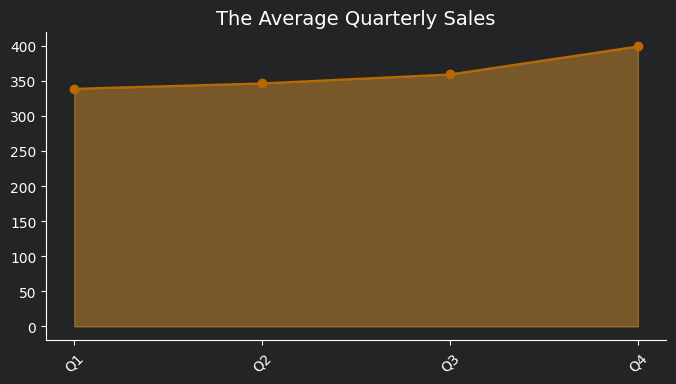

In [32]:
df_qu_sa = df_train1.groupby('quarter').agg({"sales" : "mean"}).reset_index()
# Cria a figura e os eixos para o plot
fig, ax = plt.subplots(figsize=(8, 4))  # Ajuste o tamanho conforme necessário

# Plota o gráfico de linhas com marcadores e preenchimento
ax.plot(df_qu_sa['quarter'], df_qu_sa['sales'], marker='o', linestyle='-', color='#BA6800', label='Average Quarterly Sales')
ax.fill_between(df_qu_sa['quarter'], 0, df_qu_sa['sales'], color='#FAA831', alpha=0.4)

# Personaliza os ticks do eixo x
ax.set_xticks(df_qu_sa['quarter'])
ax.set_xticklabels(['Q' + str(int(x)) for x in df_qu_sa['quarter']], rotation=45)  # Adiciona o prefixo 'Q' para cada trimestre

# Define o título e personaliza o gráfico
ax.set_title('The Average Quarterly Sales', color='white', fontsize=14)
fig.patch.set_facecolor('#232425')
ax.set_facecolor('#232425')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Desabilita a grade do gráfico para os eixos x e y
ax.grid(False)

plt.show()

Média de venda anual

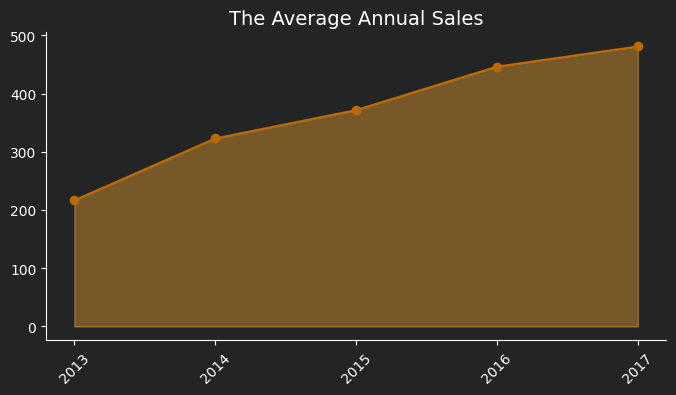

In [33]:
df_y_sa = df_train1.groupby('year').agg({"sales" : "mean"}).reset_index()
# Cria a figura e os eixos para o plot
fig, ax = plt.subplots(figsize=(8, 4))  # Ajuste o tamanho conforme necessário

# Plota o gráfico de linhas com marcadores e preenchimento
ax.plot(df_y_sa['year'], df_y_sa['sales'], marker='o', linestyle='-', color='#BA6800', label='Average Annual Sales')
ax.fill_between(df_y_sa['year'], 0, df_y_sa['sales'], color='#FAA831', alpha=0.4)

# Personaliza os ticks do eixo x
ax.set_xticks(df_y_sa['year'])
ax.set_xticklabels(df_y_sa['year'].astype(str), rotation=45)  # Converte os anos em strings para os rótulos

# Define o título e personaliza o gráfico
ax.set_title('The Average Annual Sales', color='white', fontsize=14)
fig.patch.set_facecolor('#232425')
ax.set_facecolor('#232425')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Desabilita a grade do gráfico para os eixos x e y
ax.grid(False)

plt.show()

Estados e cidades

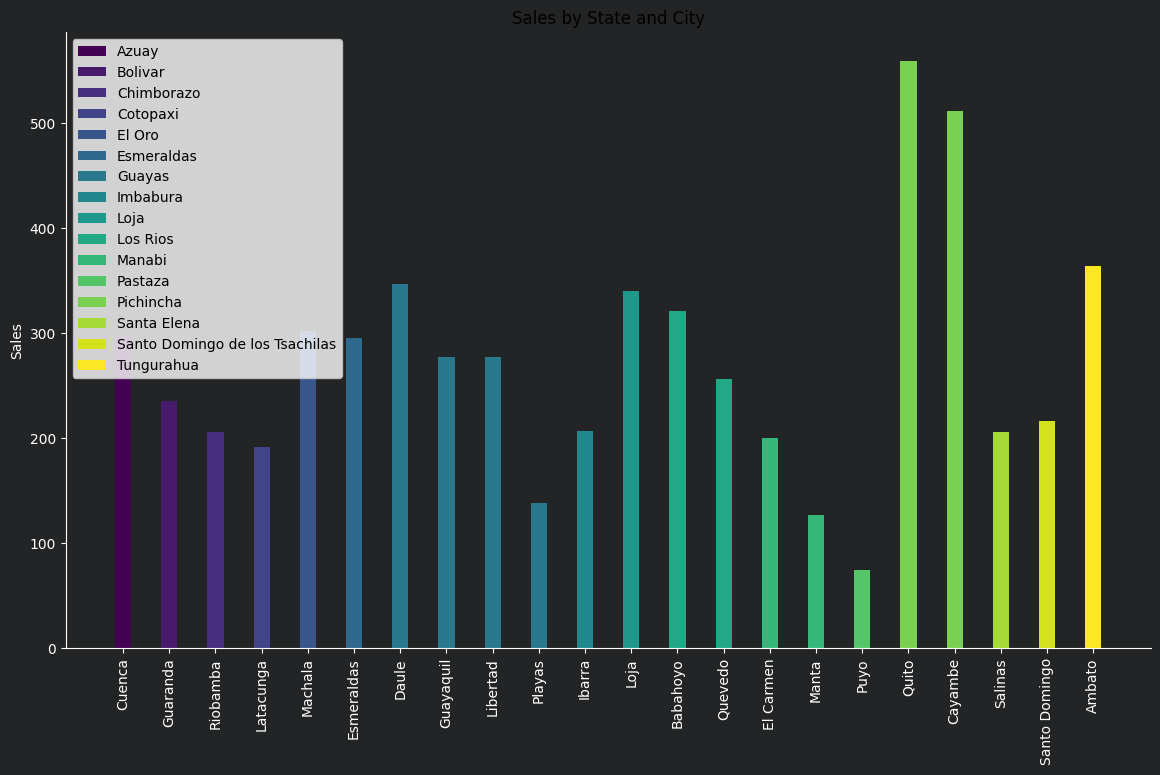

In [35]:
df_c_s_sa = df_train1.groupby(['state','city']).agg({"sales" : "mean"}).reset_index()
# Preparar os dados
df_c_s_sa = df_c_s_sa.sort_values(by=['state', 'sales'], ascending=[True, False])

# Criação de um gráfico de barras agrupadas para visualização
states = df_c_s_sa['state'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(states)))  # Usar um mapa de cores

fig, ax = plt.subplots(figsize=(14, 8))
width = 0.35  # largura das barras

for i, state in enumerate(states):
    df_state = df_c_s_sa[df_c_s_sa['state'] == state]
    ax.bar(df_state['city'], df_state['sales'], width, label=state, color=colors[i])

ax.set_ylabel('Sales')
ax.set_title('Sales by State and City')
ax.legend()

fig.patch.set_facecolor('#232425')
ax.set_facecolor('#232425')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x para melhor visualização
plt.show()